In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from io import StringIO
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [14, 9] 

from speclib import plotting

%matplotlib inline

In [2]:
datapath = '../../allan_data/RGender_.dat'

# Load data

## Mend broken lines in file

Data file is in a borked format, where there's some answer-lines that spans multiple lines, even though not there's generally answers to one question pr. line.
This code attemps to merge the broken lines.
If there's no NaN's/null values in the loaded dataset, it's probably ok.

In [3]:
rx_is_sep_space = re.compile(r'(?<=") (?=")')
with open(datapath) as fid:
    keeplines = list()
    partial_list = list()
    for line in fid:
        str_chr_cnt = len((rx_is_sep_space.findall(line)))
        if str_chr_cnt > 9:
            if partial_list:
                keeplines.append(('\t'.join(partial_list)))
                partial_list = list()
            keeplines.append(line.strip())
        else:
            partial_list.append(line.strip()) 
        

In [4]:
df = pd.read_csv(StringIO('\n'.join(keeplines)), sep=r'(?<=\")\s+(?=\")', engine='python', header=0, index_col=0).T

Strip spaces from entries

In [5]:
df = df.applymap(lambda el: el.strip())

In [6]:
df.shape

(954, 1431)

In [7]:
df.isnull().any().any() 

False

Remove `"`-characters from data, and covert to ints where applicable

In [8]:
df = df.rename(columns=lambda s: s.strip('"').replace('.', '__'), index=lambda s: s.strip('"'))

for col in df.columns:
    df.loc[:, col] = df.loc[:, col].str.strip('"')
    rx_all_ints = re.compile(r'^-?\d+$')
    if df.loc[:, col].str.match(rx_all_ints).all():  # all integers
        as_int = df.loc[:, col].astype(int)
        df.loc[:, col] = as_int

-1 seems to indicate a non-answer. Replace with NaN's

In [9]:
df = df.replace(-1, np.NaN)
df = df.replace("-1", np.NaN)

In [10]:
null_ans = ~df.isnull() 

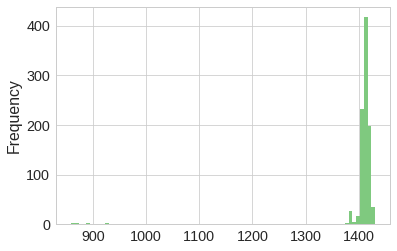

In [11]:
(null_ans.sum(axis=1)).plot.hist(80)

Users with non-null responses fewer that 1380 are discarded

In [12]:
discard_idx = ~null_ans.sum(axis=1) < 1380 

df = df[discard_idx]

Make boolean string indicators into booleans

In [13]:
str_bool_dict = {'FALSE': False, 'TRUE': True, np.NaN: np.NaN}
for col in df.columns:
    if df.loc[:, col].isin(['FALSE', 'TRUE', np.NaN]).all():  # all booleans
        df.loc[:, col] = df.loc[:, col].map(lambda el: str_bool_dict[el])

Translate the gender to english

In [14]:
str_gender_dict = {'Mand': 'male', 'Kvinde': 'female', np.NaN: np.NaN}
df.loc[:, 'gender'] = df.gender.map(lambda el: str_gender_dict[el])

## Examine column headers

In [15]:
pd.value_counts(el.rsplit('__')[-1] for el in df.columns if '__' in el) 

answer         286
question       286
response       286
condition      286
answer_type    286
dtype: int64

In [16]:
pd.value_counts(el.rsplit('__')[-1] for el in df.columns if '__'not  in el)

gender    1
dtype: int64

Seems like there's 5 attributes to each question... check that there is

In [17]:
df_cols = pd.DataFrame(el.rsplit('__') for el in df.columns if '__' in el)

In [18]:
df_cols.head(12) 

,0,1
0,function_duties,answer
1,function_duties,answer_type
2,function_duties,question
3,function_duties,response
4,function_duties,condition
5,narcissism_opponents,answer
6,narcissism_opponents,answer_type
7,narcissism_opponents,question
8,narcissism_opponents,response
9,narcissism_opponents,condition


In [19]:
df_cols.groupby(0).count()[1].value_counts()

5    286
Name: 1, dtype: int64

... and there is

### Examening data based on the answer_type columns

In [20]:
tmp = df.filter(like='_answer_type') 

tmprow = tmp.iloc[0, :]

tmprow.value_counts() 

radio           266
number           16
multi_number      2
scale             1
number;radio      1
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: int64

#### Examening the `number;radio`  type

In [21]:
tmprow.where(tmprow == 'number;radio').dropna()

alcohol_debut__answer_type    number;radio
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: object

In [22]:
tmplabel = tmprow.where(tmprow == 'number;radio').dropna().index[0].split('__')[0]
tmplabel

'alcohol_debut'

In [23]:
df_number_radio = df.filter(like=tmplabel)
df_number_radio.head() 

,alcohol_debut__answer,alcohol_debut__answer_type,alcohol_debut__question,alcohol_debut__response,alcohol_debut__condition
0010fedde8e61cad5b049da6df8b5a,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,15,False
002ee26a0c38a1f77b7cdeab8046cd,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,14,False
0037c93a19a7e90580086b462ba11b,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,15,False
005b1e0298bde6b726156aefb8d88c,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,14,False
00ad591e46eb6f3d8c474d9de9e219,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,16,False


In [24]:
for col in (df_number_radio[col] for col in df_number_radio.columns):
    print(col.value_counts().sort_index(), end='\n'*3)

0.0     34
1.0    906
Name: alcohol_debut__answer, dtype: int64


number;radio    954
Name: alcohol_debut__answer_type, dtype: int64


Hvor gammel var du første gang du drak mindst en genstand?    954
Name: alcohol_debut__question, dtype: int64


10                                 13
11                                  9
12                                 43
13                                151
14                                219
15                                272
16                                121
17                                 30
18                                 18
19                                  7
20                                  2
21                                  1
22                                  1
29                                  1
5                                   8
6                                   1
7                                   1
8                                   5
9                                   3
jeg_har_aldrig_drukket_alkohol 

In [128]:
df_number_radio.filter(regex='_answer$').notnull().sum() / df_number.shape[0]

alcohol_debut__answer    0.985325
dtype: float64

The `number;radio` type seems to a radio-button with numbers on a numerical scale. There's only a few nulls.

#### Examening the `number` answer type

In [139]:
tmprow.where(tmprow == 'number').dropna() 

alcohol_volume_sunday__answer_type       number
alcohol_volume_thursday__answer_type     number
alcohol_volume_saturday__answer_type     number
alcohol_volume_monday__answer_type       number
alcohol_volume_tuesday__answer_type      number
weight__answer_type                      number
alcohol_volume_wednesday__answer_type    number
smoke_volume_cerut__answer_type          number
function_activity__answer_type           number
height__answer_type                      number
birthyear__answer_type                   number
smoke_volume_cigar__answer_type          number
smoke_volume_pibe__answer_type           number
alcohol_volume_friday__answer_type       number
smoke_volume_cigarette__answer_type      number
know_other_number__answer_type           number
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: object

In [142]:
tmplabel = tmprow.where(tmprow == 'number').dropna().index.str.replace('__answer_type', '')
tmplabel

Index(['alcohol_volume_sunday', 'alcohol_volume_thursday',
       'alcohol_volume_saturday', 'alcohol_volume_monday',
       'alcohol_volume_tuesday', 'weight', 'alcohol_volume_wednesday',
       'smoke_volume_cerut', 'function_activity', 'height', 'birthyear',
       'smoke_volume_cigar', 'smoke_volume_pibe', 'alcohol_volume_friday',
       'smoke_volume_cigarette', 'know_other_number'],
      dtype='object')

In [143]:
df_number = df.filter(regex='|'.join(tmplabel))

df_number.head()

,alcohol_volume_sunday__answer,alcohol_volume_sunday__answer_type,alcohol_volume_sunday__question,alcohol_volume_sunday__response,alcohol_volume_sunday__condition,alcohol_volume_thursday__answer,alcohol_volume_thursday__answer_type,alcohol_volume_thursday__question,alcohol_volume_thursday__response,alcohol_volume_thursday__condition,...,smoke_volume_cigarette__answer,smoke_volume_cigarette__answer_type,smoke_volume_cigarette__question,smoke_volume_cigarette__response,smoke_volume_cigarette__condition,know_other_number__answer,know_other_number__answer_type,know_other_number__question,know_other_number__response,know_other_number__condition
0010fedde8e61cad5b049da6df8b5a,0.0,number,,0.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",15.0,number,Hvor mange?,15.0,know_other=='ja'
002ee26a0c38a1f77b7cdeab8046cd,0.0,number,,0.0,False,0.0,number,,0.0,False,...,20.0,number,,20.0,"smoke_freq=='Ja, dagligt'",NaN,number,Hvor mange?,NaN,know_other=='ja'
0037c93a19a7e90580086b462ba11b,0.0,number,,0.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",2.0,number,Hvor mange?,2.0,know_other=='ja'
005b1e0298bde6b726156aefb8d88c,1.0,number,,1.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",10.0,number,Hvor mange?,10.0,know_other=='ja'
00ad591e46eb6f3d8c474d9de9e219,0.0,number,,0.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",NaN,number,Hvor mange?,NaN,know_other=='ja'


There's a lot of dimmensions in the count, so the plot are useful for showing the values are centered around a few variables for most answers.

/lscr_paper/allan/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/indexes/api.py:71: RuntimeWarning: '<' not supported between instances of 'float' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
/lscr_paper/allan/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:5441: RuntimeWarning: '<' not supported between instances of 'float' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes)
/lscr_paper/allan/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/indexes/api.py:71: RuntimeWarning: '>' not supported between instances of 'float' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
/lscr_paper/allan/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/indexes/api.py:71: RuntimeWarning: '>' not supported between instances of 'str' and 'float', sort order is undefined for incomparable objects
  result = result.union(other)


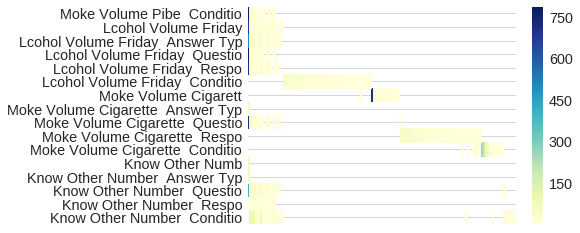

In [144]:
_ = df_number.filter(regex='__answer$').apply(pd.value_counts)
ax = sns.heatmap(_.T, xticklabels=False, cmap='YlGnBu',
                 yticklabels=[lb.strip('__answer').replace('_', ' ').title() for lb in df_number.columns])
ax.grid(which='major', axis='y')

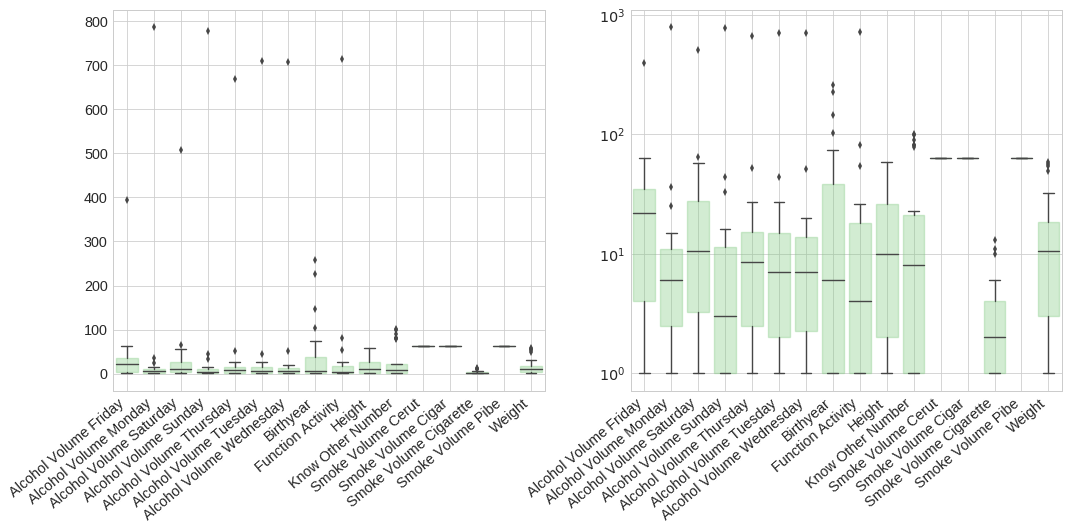

In [145]:
fig, (ax0, ax1) = plotting.boxplot_dataframe_answer_columns(df_number, matplotlib_args={'alpha': 0.35, 
                                                                                        'color': colorcycle[0]})

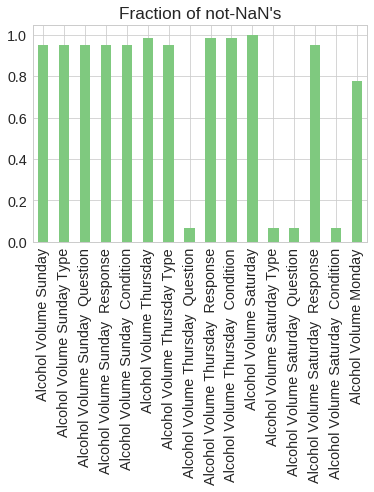

In [146]:
ax = (df_number.filter(regex='_answer$').notnull().sum() / df_number.shape[0]).plot.bar()
ax.set_xticklabels([col.replace('__answer', '').replace('_', ' ').title() for col in df_number.columns]);
ax.set_title("Fraction of not-NaN's")

It seems like the wast majority of numbers are clustered together — outlier removal may be desireable to achieve generalizable results.

A few categories have a lot of null, values and should be removed.

### Examine `radio` answer types

In [147]:
tmprow.where(tmprow == 'radio').dropna().head() 

function_duties__answer_type         radio
narcissism_opponents__answer_type    radio
locus_of_control_13__answer_type     radio
locus_of_control_12__answer_type     radio
self_efficacy_motto__answer_type     radio
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: object

In [148]:
tmplabel = tmprow.where(tmprow == 'radio').dropna().index.str.replace('__answer_type', '')
df_radio = df.filter(regex='|'.join(tmplabel)) 
df_radio.head() 

,function_duties__answer,function_duties__answer_type,function_duties__question,function_duties__response,function_duties__condition,narcissism_opponents__answer,narcissism_opponents__answer_type,narcissism_opponents__question,narcissism_opponents__response,narcissism_opponents__condition,...,selfesteem_proud__answer,selfesteem_proud__answer_type,selfesteem_proud__question,selfesteem_proud__response,selfesteem_proud__condition,narcissism_excellent__answer,narcissism_excellent__answer_type,narcissism_excellent__question,narcissism_excellent__response,narcissism_excellent__condition
0010fedde8e61cad5b049da6df8b5a,0.0,radio,At varetage dine praktiske pligter i hjemmet?,Slet ikke,False,1.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",2,False,...,2.0,radio,Jeg føler at jeg ikke har meget at være stolt af,Uenig,False,3.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,4,False
002ee26a0c38a1f77b7cdeab8046cd,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,2.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",3,False,...,2.0,radio,Jeg føler at jeg ikke har meget at være stolt af,Uenig,False,2.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,3,False
0037c93a19a7e90580086b462ba11b,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,1.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",2,False,...,1.0,radio,Jeg føler at jeg ikke har meget at være stolt af,Enig,False,1.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,2,False
005b1e0298bde6b726156aefb8d88c,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,2.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",3,False,...,2.0,radio,Jeg føler at jeg ikke har meget at være stolt af,Uenig,False,1.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,2,False
00ad591e46eb6f3d8c474d9de9e219,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,1.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",2,False,...,3.0,radio,Jeg føler at jeg ikke har meget at være stolt af,Stærkt uenig,False,0.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,Passer slet ikke 1,False


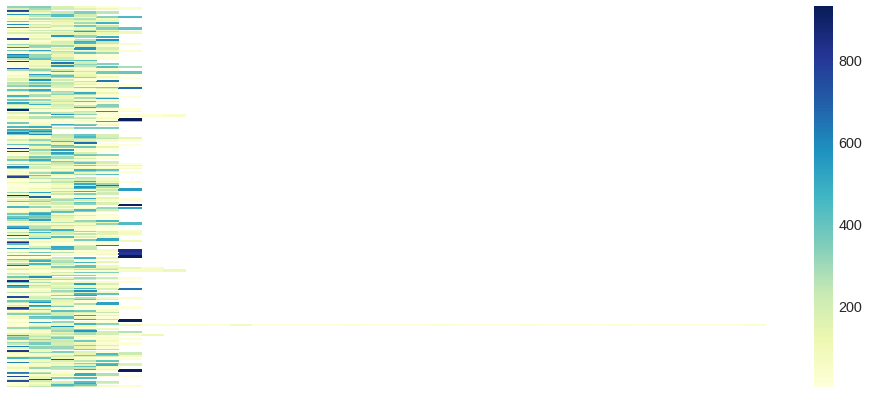

In [155]:
fig, ax = plt.subplots(figsize=(17, 7))
_ = df_radio.filter(regex='__answer$').apply(pd.value_counts)
ax = sns.heatmap(_.T, xticklabels=False, yticklabels=False, cmap='YlGnBu', ax=ax)


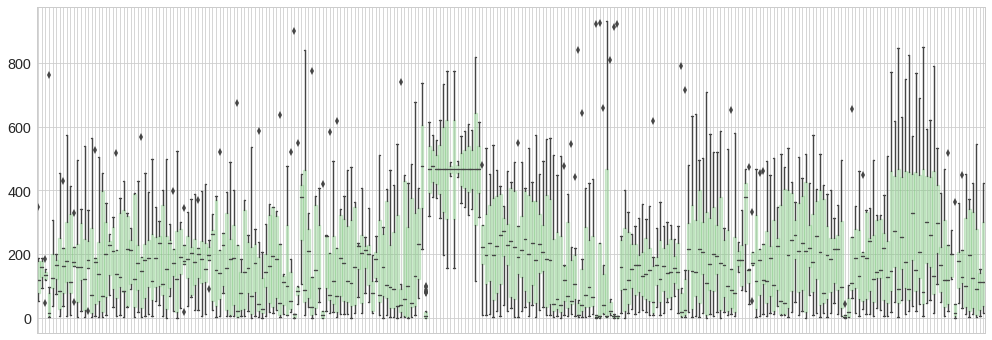

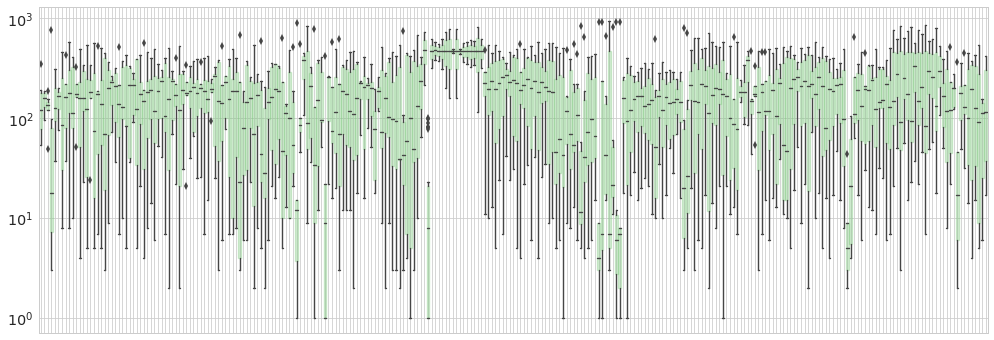

In [179]:
oldfigsize = mpl.rcParams['figure.figsize']
mpl.rcParams['figure.figsize'] = [17, 6]
(fig0, ax0), (fig1, ax1) = plotting.boxplot_dataframe_answer_columns(df_radio, subplot=False,
                                                            matplotlib_args={'alpha': 0.35, 'color': colorcycle[0]}) 
ax0.set_xticklabels(list())
ax1.set_xticklabels(list())

mpl.rcParams['figure.figsize'] = oldfigsize

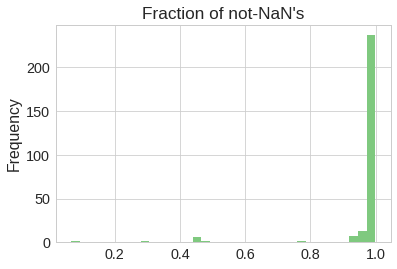

In [180]:

ax = (df_radio.filter(regex='_answer$').notnull().sum() / df_radio.shape[0]).plot.hist(bins=35)
ax.set_title("Fraction of not-NaN's") 

While 266 variables is definetly pushing the limit of the boxplot, we can though see that 

1. Most categories points seems to around or just below 200
2. There's some variables whice are significant higher, but the low standard deviation suggests that they contains a lot of `NaN`'s
3. A lot of categories have big outliers.

And from the `NaN`-fraction plot we see that there's endeed some `NaN`'s in the data.

Next, clean responses like
```

014813ebd3e875e031adf6ab717acc       Passer slet ikke 1
0149cde16952c52bd38550ba4e5c56                        4
0192d71b149f60e98272b3ad3daf05                        2
01b55a9e2a33743a3b956085974184                        3
01b752d455e97e5dd2262d339f2187       Passer slet ikke 1
01b913754e34bbac2a17afbc398702    6 Passer fuldstændigt
01bead0797b27df58534edb513d875                        4
```

Test that the regex works

In [ ]:
rx_stupid_format = re.compile(r'^(?:\D+\d+)|(?:\d+\D+)$')
tmp = pd.Series(['foo 123', '456 bar', 'biz', '789', 987])
tmp.str.match(rx_stupid_format)

In [ ]:
df_is_stupid_format = df.copy()
for col in df.columns:
    try:
        df_is_stupid_format[col] = df[col].str.match(rx_stupid_format)
    except AttributeError:
        df_is_stupid_format[col] = np.NaN

In [ ]:
df_is_stupid_format.head(15)

In [ ]:
df_is_stupid_format.shape

In [ ]:
df_is_stupid_format = df_is_stupid_format.dropna(axis=1, how='all')

In [ ]:
df_is_stupid_format.shape

In [ ]:
stupid_format_idx = df_is_stupid_format.any()[df_is_stupid_format.any()].index

In [ ]:
tmp = df.loc[:, stupid_format_idx]

In [ ]:
tmp.head() 

In [ ]:
df.filter

In [ ]:
df.filter(regex='answer|response')